In [37]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
from varclushi import VarClusHi
from sklearn.metrics import silhouette_score

from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
import keras
from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
import warnings

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
# import keras
import math

from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, GRU
from scipy import optimize
from methods import *
import warnings
from tensorflow.keras import optimizers
warnings.filterwarnings("ignore")
%matplotlib inline

warnings.filterwarnings('ignore')
print("okay")

okay


In [38]:
SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

### Dataset

In [57]:
# Load data and preprocess
# with tf.device('/device:GPU:1'):
if True:
    train, test, y_test = prepare_data('FD001.txt')
    print(train.shape, test.shape, y_test.shape)
    sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

    remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
                    'NRf','NRc','BPR', 'farB','htBleed','W31','W32'] # selection based on main_notebook

    drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

(20631, 27) (13096, 26) (100, 1)


In [5]:
## Data cleaning
alpha = 0.4
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,42.0,0.84,100.0,0.0,0.500000,0.255293,0.278866,0.0,...,0.175935,0.602638,0.0,0.363636,0.0,0.0,0.460000,0.473138,320,42.0_0.84_100.0
1,1,2,20.0,0.70,100.0,0.0,0.258396,0.305183,0.240571,0.0,...,0.138181,0.587018,0.0,0.193182,0.0,0.0,0.358569,0.415175,319,20.0_0.7_100.0
2,1,3,42.0,0.84,100.0,0.0,0.273393,0.276540,0.296227,0.0,...,0.131676,0.665650,0.0,0.233766,0.0,0.0,0.338891,0.491114,318,42.0_0.84_100.0
3,1,4,42.0,0.84,100.0,0.0,0.246611,0.246481,0.328519,0.0,...,0.155465,0.639913,0.0,0.209893,0.0,0.0,0.357783,0.521772,317,42.0_0.84_100.0
4,1,5,25.0,0.62,60.0,0.0,0.235347,0.278651,0.264774,0.0,...,0.162346,0.582346,0.0,0.263432,0.0,0.0,0.298987,0.566841,316,25.0_0.62_60.0


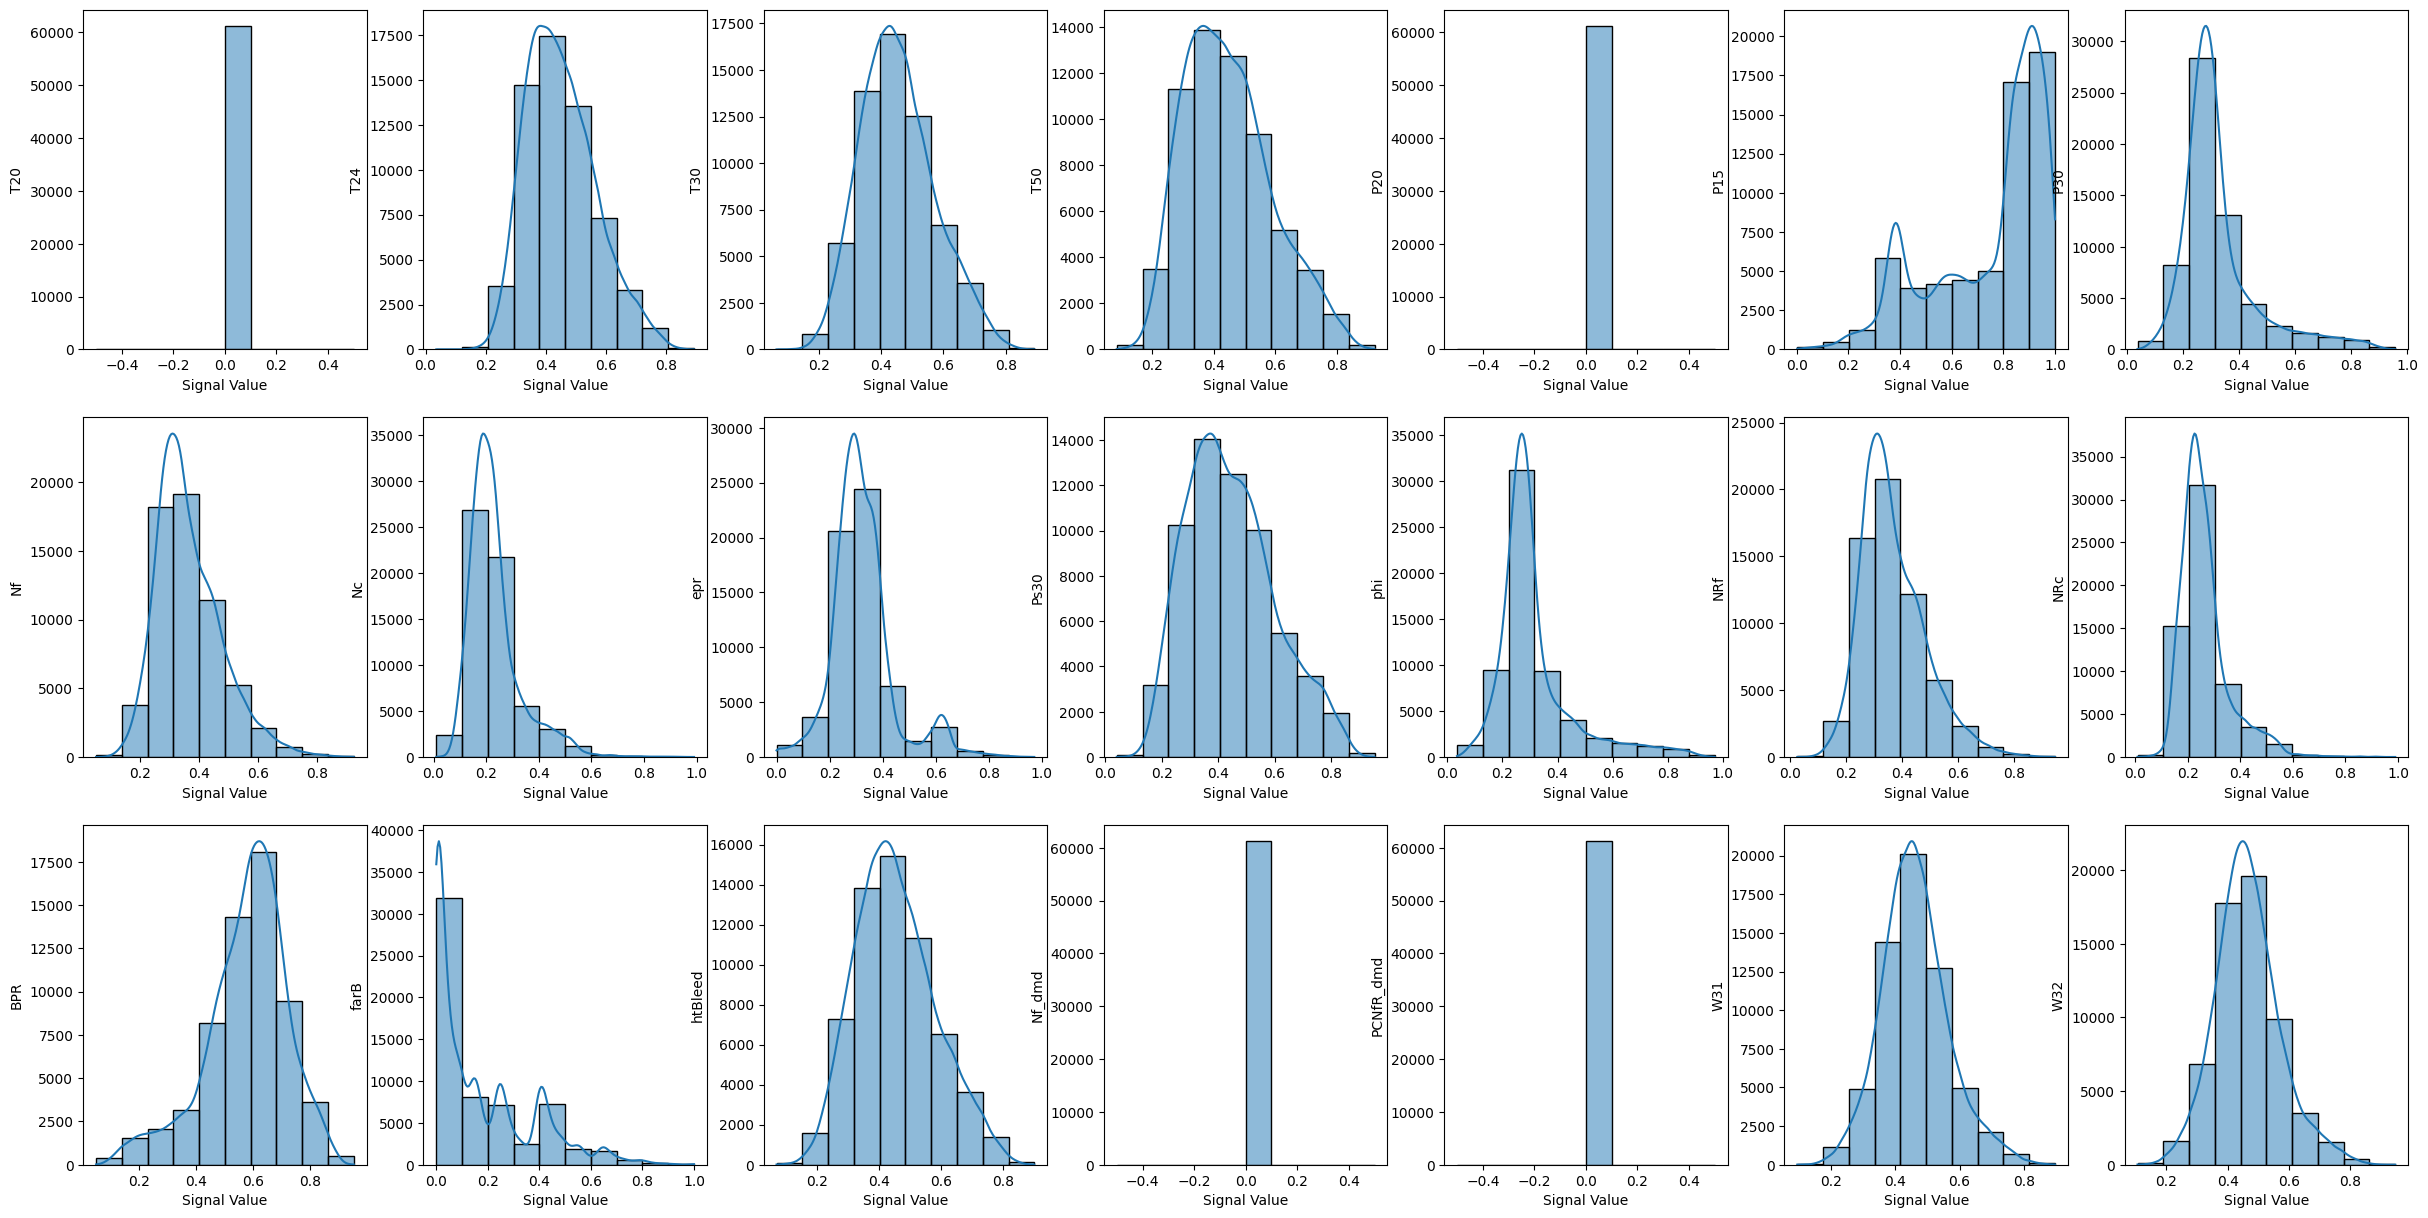

In [58]:
plt.figure(figsize=(30,15))
for s in range(len(sensor_names)):
    signal = X_train_interim[sensor_names[s]]
    # Plotting the histogram and density plot
    # plt.figure(figsize=(10, 6))
    plt.subplot(3,7,s+1)
    sns.histplot(signal, kde=True, bins=10)  # kde=True adds a kernel density estimate
    # plt.title("Distribution of Signal")
    plt.xlabel("Signal Value")
    plt.ylabel(signal.name)
plt.savefig('images/data_distribution.png')

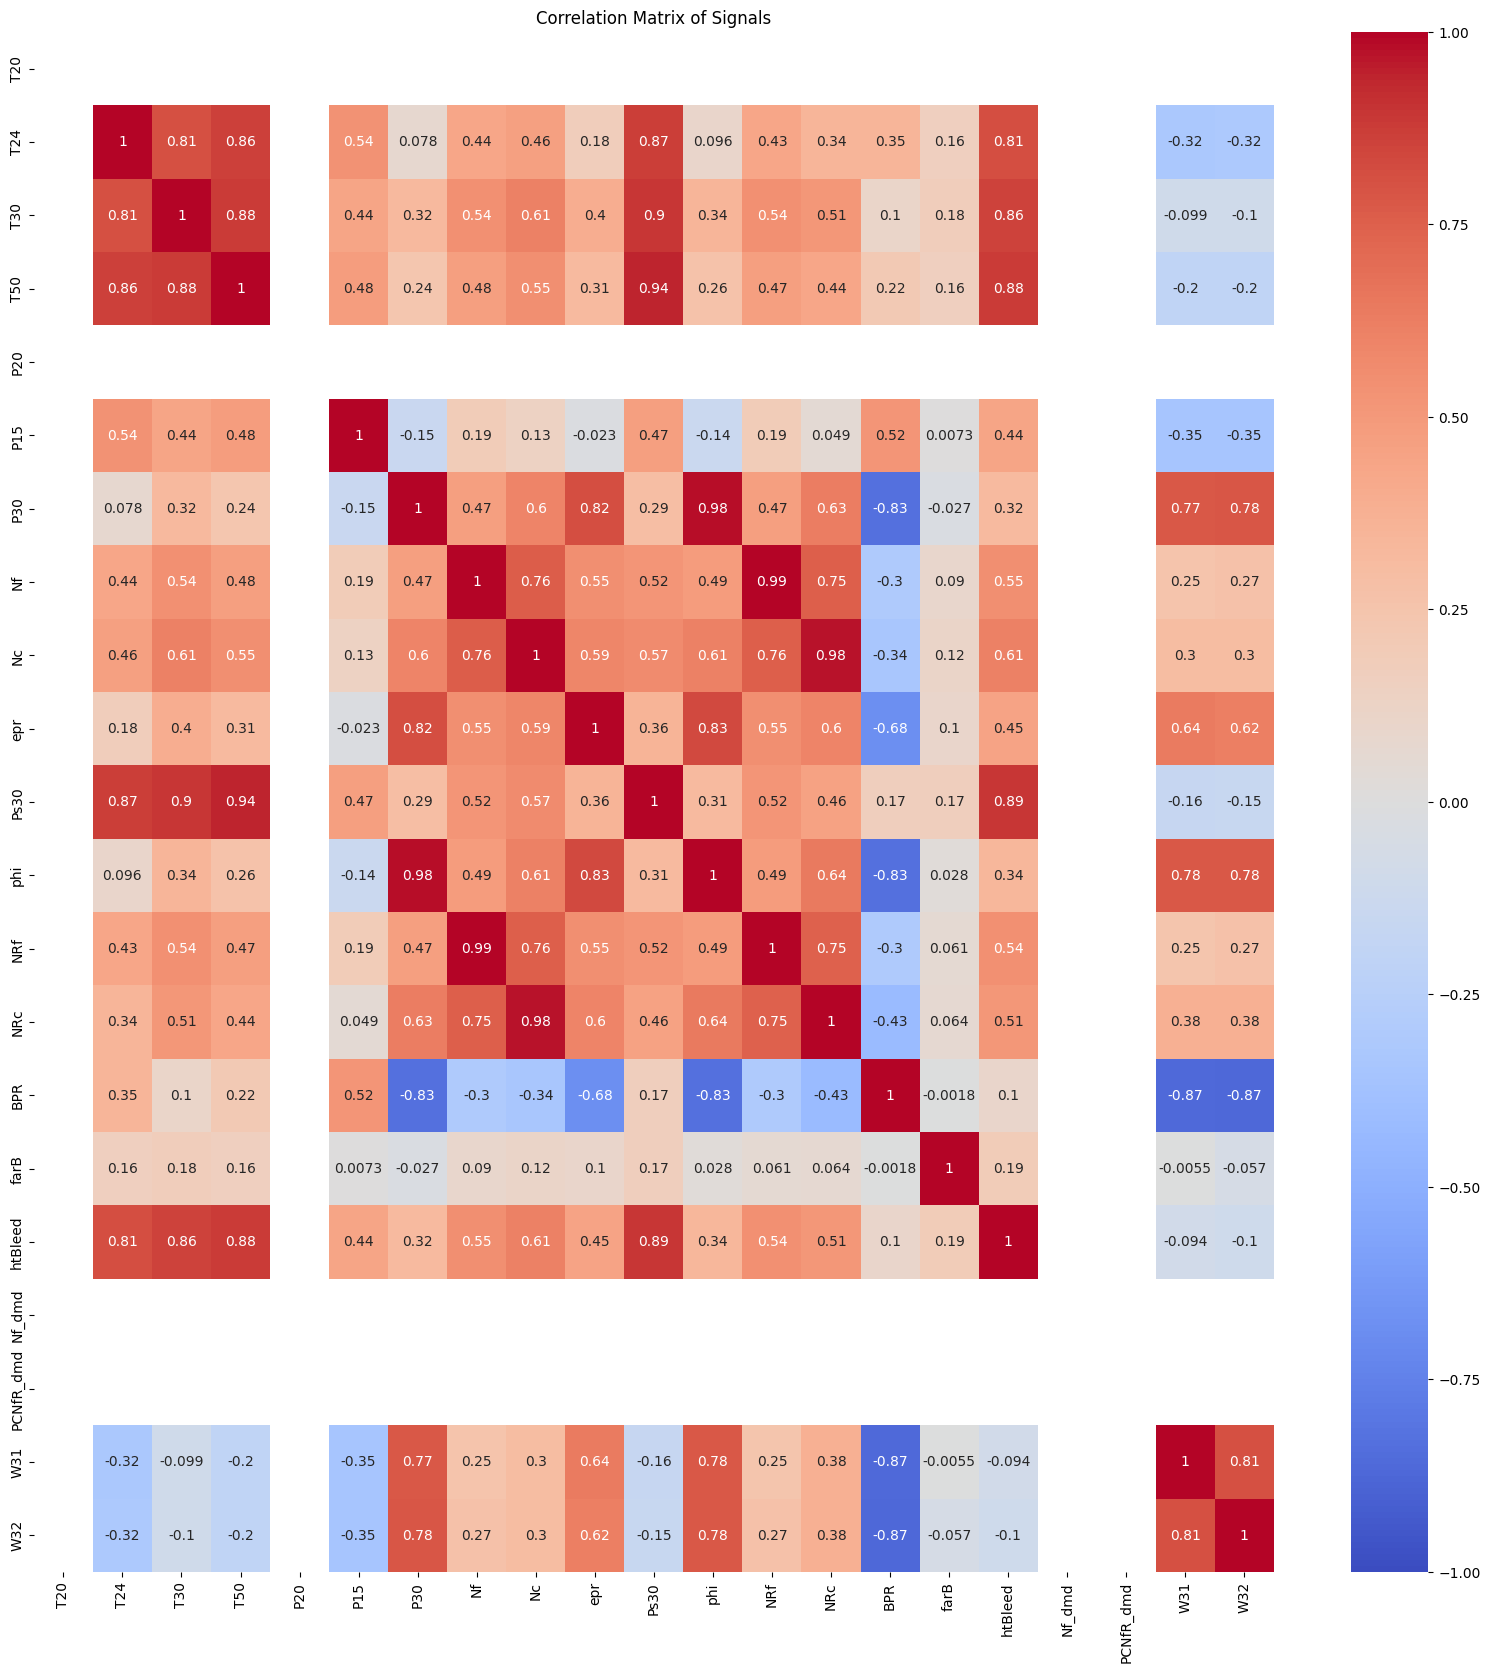

In [59]:
# Calcul de la matrice de corrélation
correlation_matrix = X_train_interim[sensor_names].corr(method='pearson')

# Affichage de la matrice de corrélation avec heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Signals")
plt.show()

In [60]:
remaining_sensors_001 = ['T24','T30','T50', 'P15', 'P30','Nf','Nc','Ps30','phi',
                    'NRf','NRc','BPR','htBleed','W31','W32']
remaining_sensors_002 = remaining_sensors
remaining_sensors_003 = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
                    'NRf','NRc','BPR','htBleed','W31','W32']
remaining_sensors_004 = remaining_sensors


In [61]:
X = X_train_interim[remaining_sensors_001]
X.to_csv("data_cleaned/X_cleaned001.csv")
resclv = VarClusHi(X,maxeigval2=1,maxclus=None)
resclv.varclus()

In [62]:
init_partition  = resclv.rsquare.Cluster.values
init_partition = pd.DataFrame(init_partition)
print(init_partition.shape)
init_partition.columns = ["cluster"]
init_partition.to_csv("init_partition/init_partition001.csv")

(15, 1)


In [ ]:
# features retained
# [1] "Ps30"
# [1] "Nf"
# [1] "phi"
# [1] "BPR"  
# "farB"

In [168]:
remaining_sensors = ["Ps30", "Nf", "phi", "BPR", "farB"]

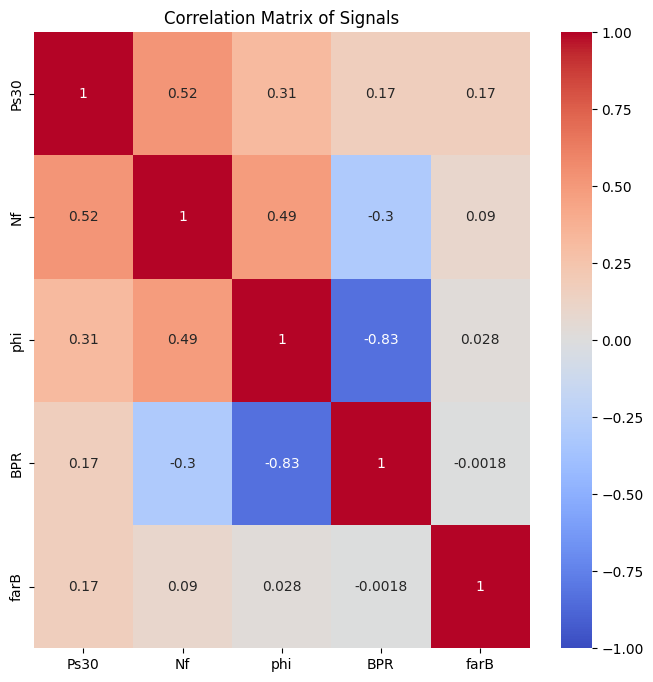

In [94]:
# Calcul de la matrice de corrélation
correlation_matrix = X_train_interim[remaining_sensors].corr(method='pearson')

# Affichage de la matrice de corrélation avec heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Signals")
plt.show()

In [137]:
df = pd.DataFrame()
training_path = 'PRONOSTIA/Learning_set'
bearing = 'Bearing1_1'
base_dir = os.path.join(training_path, bearing)

def data_load(base_dir):
    list_df = []
    for f in sorted(os.listdir(base_dir)):
        d = pd.read_csv(os.path.join(base_dir, f), header=None, names=['hour', 'minute', 'second', 'microsecond', 'horiz accel', 'vert accel'])
        if d.shape[0] == 2560:
            list_df.append(d)
    return pd.concat(list_df)
    

In [140]:
len(os.listdir(base_dir))

3269

In [141]:
DATA_POINTS_PER_FILE = 2560
 
df = data_load(base_dir)
no_of_rows = df.shape[0]

no_of_files = int(no_of_rows / DATA_POINTS_PER_FILE)
print(no_of_rows, no_of_files)

600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600


In [139]:
df

,hour,minute,second,microsecond,horiz accel,vert accel
0,9,39,39,65664.0,0.552,-0.146
1,9,39,39,65703.0,0.501,-0.480
2,9,39,39,65742.0,0.138,0.435
3,9,39,39,65781.0,-0.423,0.240
4,9,39,39,65820.0,-0.802,0.020
...,...,...,...,...,...,...
2555,17,26,39,165470.0,-3.353,2.129
2556,17,26,39,165510.0,-2.868,-2.299
2557,17,26,39,165550.0,-5.507,-1.844
2558,17,26,39,165580.0,-3.578,2.146


In [ ]:
def read_data_as_df(base_dir):
'''
    saves each file in the base_dir as a df and concatenate all dfs into one
'''
  if base_dir[-1]!='/':
    base_dir += '/'

  dfs=[]
  for f in sorted(os.listdir(base_dir)):
    print(f)
    df=pd.read_csv(base_dir+f, header=None, names=['hour', 'minute', 'second', 'microsecond', 'horiz accel', 'vert accel'])
    dfs.append(df)
  return pd.concat(dfs)

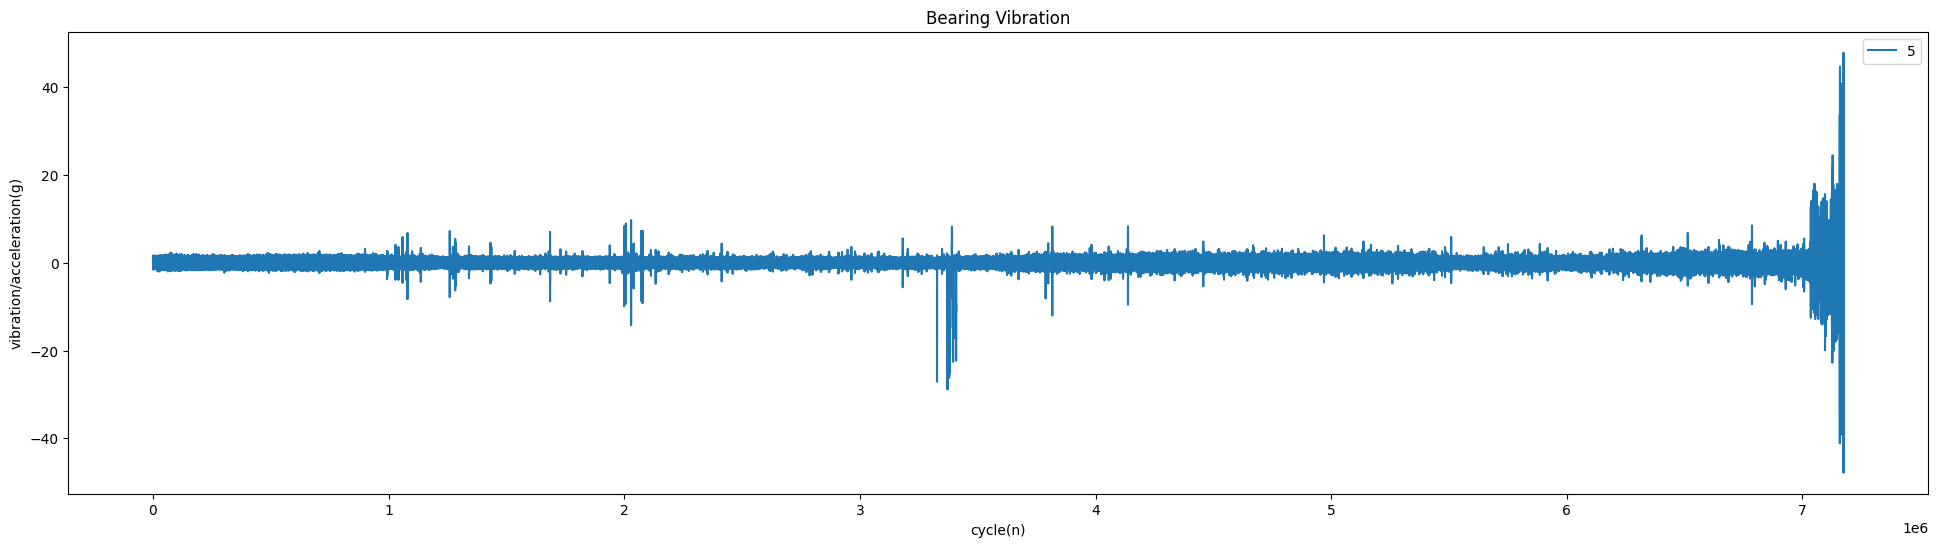

In [95]:
ax = df.iloc[:,5].plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

In [146]:
import pandas as pd
import os

# Définissez le chemin du dossier contenant les fichiers de données
data_folder = base_dir

# Chargement des fichiers de vibration
vibration_files = [f for f in os.listdir(data_folder) if f.startswith('acc_') and f.endswith('.csv')]
vibration_data = []

for file in vibration_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path, names=['Hour', 'Minute', 'Second', 'Microsecond', 'Horizontal_Accel', 'Vertical_Accel'])
    
    # Extraction de l'identifiant du roulement à partir du nom de fichier
    bearing_id = file.split('_')[1].split('.')[0]
    df['bearing_id'] = bearing_id
    
    # Calcul du cycle en fonction de l'enregistrement toutes les 10 secondes
    df['cycle'] = df.index // 10  # Approximation en supposant un enregistrement toutes les 10 secondes
    vibration_data.append(df)

# Concatenation de toutes les données de vibration en un seul DataFrame
vibration_data = pd.concat(vibration_data, ignore_index=True)

# Calcul de la RUL pour chaque roulement
failure_cycles = vibration_data.groupby('bearing_id')['cycle'].max()
vibration_data['RUL'] = vibration_data.apply(lambda row: failure_cycles[row['bearing_id']] - row['cycle'], axis=1)

# Affichage des premières lignes pour vérifier le résultat
print(vibration_data.head())


   Hour  Minute  Second  Microsecond  Horizontal_Accel  Vertical_Accel  \
0     9      39      39      65664.0             0.552          -0.146   
1     9      39      39      65703.0             0.501          -0.480   
2     9      39      39      65742.0             0.138           0.435   
3     9      39      39      65781.0            -0.423           0.240   
4     9      39      39      65820.0            -0.802           0.020   

  bearing_id  cycle  RUL  
0      00001      0  255  
1      00001      0  255  
2      00001      0  255  
3      00001      0  255  
4      00001      0  255  


In [164]:
import pandas as pd
import os

# Définir le chemin du dossier contenant les fichiers de données
# data_folder = 'chemin/vers/dossier_donnees'

# Chargement des fichiers de vibration
vibration_files = [f for f in os.listdir(data_folder) if f.startswith('acc_') and f.endswith('.csv')]
vibration_data = []

for file in vibration_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path, names=['Hour', 'Minute', 'Second', 'Microsecond', 'Horizontal_Accel', 'Vertical_Accel'])
    
    # Extraction de l'identifiant du roulement
    bearing_id = file.split('_')[1].split('.')[0]
    df['bearing_id'] = bearing_id
    
    # Calculer le temps en secondes pour chaque échantillon
    df['time_seconds'] = df['Hour'] * 3600 + df['Minute'] * 60 + df['Second'] + df['Microsecond'] * 1e-6
    vibration_data.append(df)

# Concaténer toutes les données de vibration
vibration_data = pd.concat(vibration_data, ignore_index=True)

# Calcul du temps total de l'expérience (tend) pour chaque roulement
tend = vibration_data.groupby('bearing_id')['time_seconds'].max()

# Calcul de la RUL pour chaque échantillon en utilisant la formule donnée
vibration_data['RUL'] = vibration_data.apply(
    lambda row: (tend[row['bearing_id']] - row['time_seconds']) / tend[row['bearing_id']],
    axis=1
)

# Afficher les premières lignes pour vérifier
print(vibration_data[['bearing_id', 'time_seconds', 'RUL']].head())


  bearing_id  time_seconds       RUL
0      00001  34779.065664  0.000003
1      00001  34779.065703  0.000003
2      00001  34779.065742  0.000003
3      00001  34779.065781  0.000003
4      00001  34779.065820  0.000003


In [168]:
vibration_data.RUL.min()

0.0

In [165]:
len(vibration_data.RUL.unique())

7170319

In [151]:
# Chargement des fichiers de température
temperature_files = [f for f in os.listdir(data_folder) if f.startswith('temp_') and f.endswith('.csv')]
temperature_data = []

for file in temperature_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path, names=['Hour', 'Minute', 'Second', 'Subsecond', 'Temperature'])
    
    # Extraction de l'identifiant du roulement à partir du nom de fichier
    bearing_id = file.split('_')[1].split('.')[0]
    df['bearing_id'] = bearing_id
    
    temperature_data.append(df)

# Concatenation de toutes les données de température en un seul DataFrame
temperature_data = pd.concat(temperature_data, ignore_index=True)

# Affichage des premières lignes pour vérifier le résultat
print(temperature_data.head())


   Hour  Minute  Second  Subsecond  Temperature bearing_id
0     9      40      47          5       70.378      00001
1     9      40      47          6       70.378      00001
2     9      40      47          7       70.397      00001
3     9      40      47          8       70.397      00001
4     9      40      47          9       70.418      00001
